**1. Importar bibliotecas necessárias**

Usaremos:

yfinance → para baixar dados do Yahoo Finance.

pandas, numpy → manipulação de dados.

matplotlib, seaborn → gráficos.

cvxpy ou gurobipy → resolver o problema de otimização.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**2. Baixar os dados dos índices**

Precisamos de 7 anos de histórico do IBOV e do S&P100.

/tmp/ipython-input-2988350642.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_ibov = yf.download(ibov, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2988350642.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


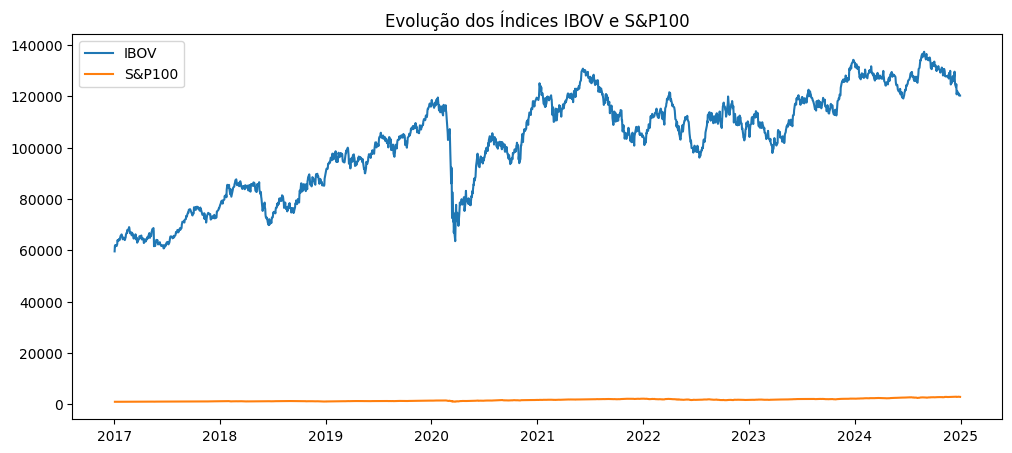

In [ ]:
# Definir datas
start_date = "2017-01-01"
end_date = "2024-12-31"

# Índices
ibov = "^BVSP"
sp100 = "^OEX"

# Baixar os preços de fechamento ajustados
dados_ibov = yf.download(ibov, start=start_date, end=end_date)["Close"]
dados_sp100 = yf.download(sp100, start=start_date, end=end_date)["Close"]

plt.figure(figsize=(12,5))
plt.plot(dados_ibov, label="IBOV")
plt.plot(dados_sp100, label="S&P100")
plt.legend()
plt.title("Evolução dos Índices IBOV e S&P100")
plt.show()

**Achou estranho o grafico acima?**

Faz sentido, porque:
O IBOVESPA é um índice de pontos (60.000 → 140.000).

O S&P100 (^OEX) também é em pontos, mas em uma escala muito menor (entre ~500 e ~1000 nos últimos anos).

Como a gente plota ambos no mesmo eixo Y, o IBOV domina a escala, e o S&P100 parece quase uma linha reta próxima de zero.

**Soluções para visualizar melhor:**

Normalizar ambos os índices (base 100) – assim você compara a evolução percentual.

Plotar em eixos diferentes (dual axis) – cada índice no seu eixo Y.

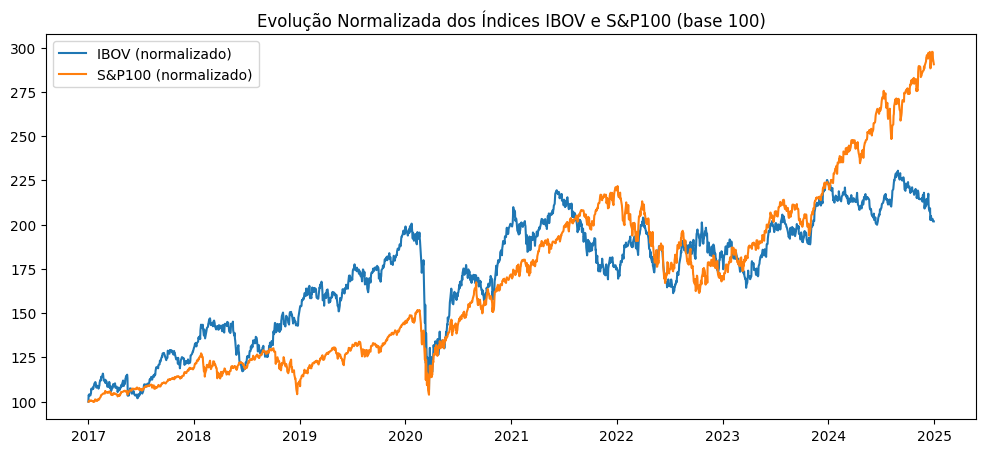

In [ ]:
#Exemplo com normalização (base 100 no início da série):
plt.figure(figsize=(12,5))

dados_ibov_norm = dados_ibov / dados_ibov.iloc[0] * 100
dados_sp100_norm = dados_sp100 / dados_sp100.iloc[0] * 100

plt.plot(dados_ibov_norm, label="IBOV (normalizado)")
plt.plot(dados_sp100_norm, label="S&P100 (normalizado)")
plt.legend()
plt.title("Evolução Normalizada dos Índices IBOV e S&P100 (base 100)")
plt.show()


**3. Baixar os componentes dos índices**

IBOV: lista de ações pode ser buscada no site da B3.

S&P100: lista de tickers está disponível no Yahoo Finance.

In [ ]:
# Exemplo com tickers do S&P100 (resumido, depois buscamos todos)
tickers_sp100 = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]

# Baixar dados de preços
dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]
dados_acoes.head()


/tmp/ipython-input-412946279.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_acoes = yf.download(tickers_sp100, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2017-01-03,26.796843,37.683498,40.123764,116.144012,56.404678
2017-01-04,26.766842,37.859001,40.111843,117.962791,56.152317
2017-01-05,26.902954,39.022499,40.372555,119.930664,56.152317
2017-01-06,27.202885,39.799500,40.977871,122.653877,56.639027
2017-01-09,27.452049,39.846001,41.075699,124.134743,56.458759


**4. Tratar os dados**

Conferir valores faltantes.

Remover ativos com muitos dados ausentes.

Tratar outliers, se necessário.

In [ ]:
# Checar dados faltantes
print(dados_acoes.isnull().sum())

# Remover colunas com mais de 10% de valores nulos
dados_acoes = dados_acoes.dropna(axis=1, thresh=int(0.9*len(dados_acoes)))


Ticker
AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
dtype: int64


**5. Calcular retornos**

In [ ]:
# Retornos logarítmicos
retornos = np.log(dados_acoes / dados_acoes.shift(1)).dropna()

# Retorno do índice
retorno_indice = np.log(dados_sp100 / dados_sp100.shift(1)).dropna()


**6. Montar o modelo de otimização**

Objetivo: minimizar o erro entre o retorno da carteira e o retorno do índice.

Variáveis: pesos
𝑤
𝑖
w
i
	​

 das ações.

Restrições:

∑
𝑤
𝑖
=
1
∑w
i
	​

=1

𝑤
𝑖
≥
0
w
i
	​

≥0 (sem venda a descoberto, opcional)

Número máximo de ativos na carteira.

In [ ]:
import cvxpy as cp

n = retornos.shape[1]
w = cp.Variable((n, 1))  # Reshape w to be a column vector

# Erro quadrático entre índice e carteira
erro = cp.norm(retornos.values @ w - retorno_indice.values.flatten().reshape(-1, 1), "fro")

# Restrições
restricoes = [cp.sum(w) == 1, w >= 0]

# Problema de otimização
problema = cp.Problem(cp.Minimize(erro), restricoes)
problema.solve()

pesos = w.value

**7. Validar a carteira**

Comparar desempenho da carteira com o índice.

Fazer backtest dentro e fora da amostra.

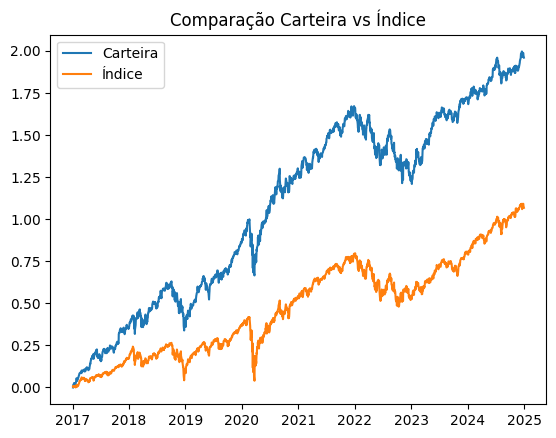

In [ ]:
carteira = (retornos @ pesos).cumsum()
indice = retorno_indice.cumsum()

plt.plot(carteira, label="Carteira")
plt.plot(indice, label="Índice")
plt.legend()
plt.title("Comparação Carteira vs Índice")
plt.show()


**8. Criar cenários fora da amostra (Explorem)**

A ideia é:

Dividir os dados em treino (ex: 2017–2022) e teste (2023–2024). (minha escolha)

Rodar o modelo no período de treino → gerar os pesos da carteira.

Testar essa carteira no período de teste → ver se ela acompanha o índice.

Repetir esse processo algumas vezes para ter 5 carteiras fora da amostra.

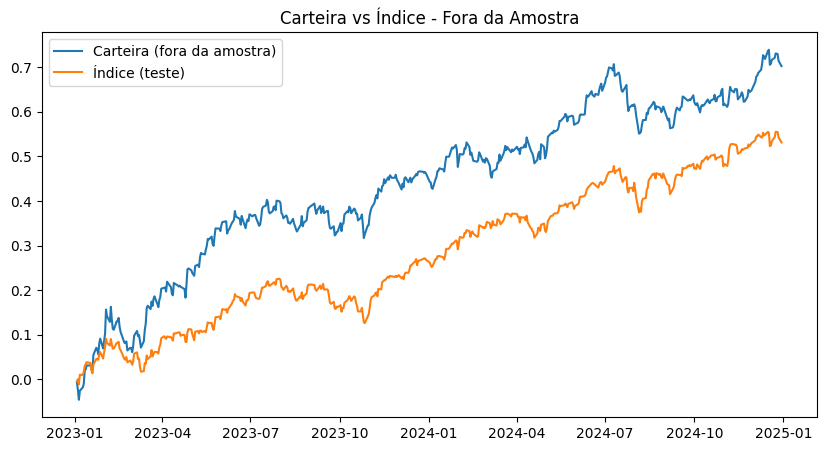

In [ ]:
# Dividir em treino e teste
data_split = "2023-01-01"

retornos_treino = retornos.loc[:data_split]
retornos_teste = retornos.loc[data_split:]

retorno_indice_treino = retorno_indice.loc[:data_split]
retorno_indice_teste = retorno_indice.loc[data_split:]

# Modelo de otimização no treino
n = retornos_treino.shape[1]
w = cp.Variable((n, 1)) # Reshape w to be a column vector

erro = cp.norm(retornos_treino.values @ w - retorno_indice_treino.values.reshape(-1, 1), "fro")
restricoes = [cp.sum(w) == 1, w >= 0]

problema = cp.Problem(cp.Minimize(erro), restricoes)
problema.solve()

pesos_treino = w.value

# Carteira no teste
carteira_teste = (retornos_teste @ pesos_treino).cumsum()
indice_teste = retorno_indice_teste.cumsum()

# Plotar
plt.figure(figsize=(10,5))
plt.plot(carteira_teste, label="Carteira (fora da amostra)")
plt.plot(indice_teste, label="Índice (teste)")
plt.legend()
plt.title("Carteira vs Índice - Fora da Amostra")
plt.show()

**Etapa 9 – Métricas de avaliação**
Além do gráfico, é bom calcular métricas:

Tracking Error (TE):

𝑇
𝐸
=
1
𝑇
∑
(
𝑅
𝑐
−
𝑅
𝑖
)
2
TE=
T
1
	​

∑(R
c
	​

−R
i
	​

)
2
	​


Correlação entre índice e carteira.

Erro Médio Absoluto (MAE).

In [ ]:
# Tracking Error
portfolio_returns_test = retornos_teste @ pesos_treino
tracking_error = np.sqrt(np.mean((portfolio_returns_test - pd.Series(retorno_indice_teste.values.flatten(), index=portfolio_returns_test.index))**2))

# Correlação
correlacao = np.corrcoef(portfolio_returns_test.values.flatten(), retorno_indice_teste.values.flatten())[0,1]

print("Tracking Error:", tracking_error)
print("Correlação:", correlacao)

Tracking Error: nan
Correlação: 0.847809868448036
